In [1]:
import umap
import numpy as np
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis

%pylab
%matplotlib notebook

Using matplotlib backend: <object object at 0x7f38e1b51670>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
aas = 'ACDEFGHIKLMNPQRSTVWY'
hydropathies = {}
hydropathies['Eisenberg'] = [ProteinAnalysis(aa).gravy('Eisenberg') for aa in aas]
hydropathies['Kyte-Doolittle'] = [ProteinAnalysis(aa).gravy() for aa in aas]
hydropathies['WatTM'] = [-val for val in 
                         [-0.554573, -0.43652, 0.180008, 0.172182, -0.385716, 
                          0.112075, 0.167345, -0.645392, 0.286421, -0.689301, 
                          -0.499782, 0.255488, 0.228476, 0.204982, 0.272773, 
                          0.150285, 0.221379, -0.650611, -0.610238, -0.157312]
                        ]

def hydrophobic_moment(seq, scale='Eisenberg'):
    seq_hydropathies = np.array([hydropathies[scale][aas.index(aa)] for aa in seq])
    angles = np.pi * 5. / 9. * np.arange(len(seq)) # 5/9 = 100/180
    hydrophobicity_vectors = seq_hydropathies * np.vstack([np.cos(angles), np.sin(angles)])
    return np.linalg.norm(hydrophobicity_vectors.mean(axis=1))

def gravy(seq, scale='Kyte-Doolittle'):
    seq_hydropathies = np.array([hydropathies[scale][aas.index(aa)] for aa in seq])
    return np.mean(seq_hydropathies)

In [3]:
def normalize_column(A, col_index, col_min=None, col_max=None):
    if col_min is None:
        col_min = A[:, col_index].min()
    if col_max is None:
        col_max = A[:, col_index].max()
    A[:, col_index] = (A[:, col_index] - col_min) / (col_max - col_min)
    return col_min, col_max

In [4]:
df_sol = pd.read_csv('files/Sol_raw.csv')
df_TM = pd.read_csv('files/TM_raw.csv')

In [5]:
df_train = pd.concat([df_TM, df_sol], ignore_index=True)
labels = np.hstack([np.array(['TM'] * len(df_TM)), np.array(['Sol'] * len(df_sol))])

In [6]:
df_test = pd.read_csv('files/Experiment_combined.csv').drop_duplicates('Sequence')

### Define Functions for Plotting

In [7]:
# From https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-to-a-plot

def interactive_plot(tm_embedding, sol_embedding, exp_embedding, 
                     train_set=None, test_set=None, 
                     min_val=0., max_val=1., color_by='provenance'):
    all_embedding = np.vstack([tm_embedding, sol_embedding, exp_embedding])
    
    fig, ax = subplots()
    
    if color_by == 'provenance':
        cmap = plt.cm.YlGnBu
        c = np.hstack([0.3 * np.ones(len(tm_embedding)), 
                       2. * np.ones(len(sol_embedding)), 
                       np.ones(len(exp_embedding))])
        ec = ec = ['none'] * (len(tm_embedding) + len(sol_embedding)) + ['black'] * len(exp_embedding)
        norm = plt.Normalize(0., 2.)
    elif color_by == 'gravy':
        cmap = plt.cm.YlGnBu
        c = -np.hstack([train_set[:, 20], test_set[:, 20]])
        ec = ['none'] * len(train_set) + ['black'] * len(test_set)
        norm = plt.Normalize(c.min() - 0.1 * (c.max() - c.min()), c.max())
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    elif color_by == 'length':
        cmap = plt.cm.RdBu
        c = np.hstack([train_set[:, 21], test_set[:, 21]])
        c = c * (max_val - min_val) + min_val
        ec = ['none'] * len(train_set) + ['black'] * len(test_set)
        norm = plt.Normalize(c.min(), c.max())
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    elif color_by == 'charge':
        cmap = plt.cm.RdBu
        c = np.hstack([train_set[:, 22], test_set[:, 22]])
        c = c * (max_val - min_val) + min_val
        ec = ['none'] * len(train_set) + ['black'] * len(test_set)
        norm = plt.Normalize(c.min(), c.max())
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    elif color_by == 'moment':
        cmap = plt.cm.cool
        c = -np.hstack([train_set[:, 23], test_set[:, 23]])
        c -= c.min()
        ec = ['none'] * len(train_set) + ['black'] * len(test_set)
        norm = plt.Normalize(c.min(), c.max())
        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    s = np.hstack([10 * np.ones(len(tm_embedding)), 
                   10 * np.ones(len(sol_embedding)), 
                   50 * np.ones(len(exp_embedding))])
    names = list(df_TM.seq) + list(df_sol.seq) + list(df_test.Sequence)
    
    sc = ax.scatter(all_embedding[:, 0], all_embedding[:, 1], 
                    c=c, s=s, edgecolors=ec, cmap=cmap, norm=norm)
    
    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    
    annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    
    def update_annot(ind):
        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = " ".join([names[n] for n in ind["ind"]])
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    
    fig.canvas.mpl_connect("motion_notify_event", hover)

### Reproduce "e" shape

In [8]:
umap_train_set = np.zeros((len(df_train), 24))
for i, seq in zip(range(len(df_train)), df_train.seq):
    X = ProteinAnalysis(seq)
    _ = X.get_amino_acids_percent()
    umap_train_set[i, :20] = np.array(list(X.amino_acids_percent.values()))
    umap_train_set[i, 20] = gravy(seq)
    umap_train_set[i, 21] = len(seq)
    umap_train_set[i, 22] = X.isoelectric_point()
    umap_train_set[i, 23] = hydrophobic_moment(seq)
len_min, len_max = normalize_column(umap_train_set, 21)
iso_min, iso_max = normalize_column(umap_train_set, 22)

In [9]:
umap_test_set = np.zeros((len(df_test), 24))
for i, seq in zip(range(len(df_test)), df_test.Sequence):
    X = ProteinAnalysis(seq)
    _ = X.get_amino_acids_percent()
    umap_test_set[i, :20] = np.array(list(X.amino_acids_percent.values()))
    umap_test_set[i, 20] = gravy(seq)
    umap_test_set[i, 21] = len(seq)
    umap_test_set[i, 22] = X.isoelectric_point()
    umap_test_set[i, 23] = hydrophobic_moment(seq)
_ = normalize_column(umap_test_set, 21, len_min, len_max)
_ = normalize_column(umap_test_set, 22, iso_min, iso_max)

In [10]:
mapper = umap.UMAP(random_state=42).fit(umap_train_set)
tm_embedding = mapper.transform(umap_train_set[:len(df_TM)])
sol_embedding = mapper.transform(umap_train_set[len(df_TM):])
exp_embedding = mapper.transform(umap_test_set)

/home/kormos/anaconda3/envs/env_umap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<IPython.core.display.Javascript object>


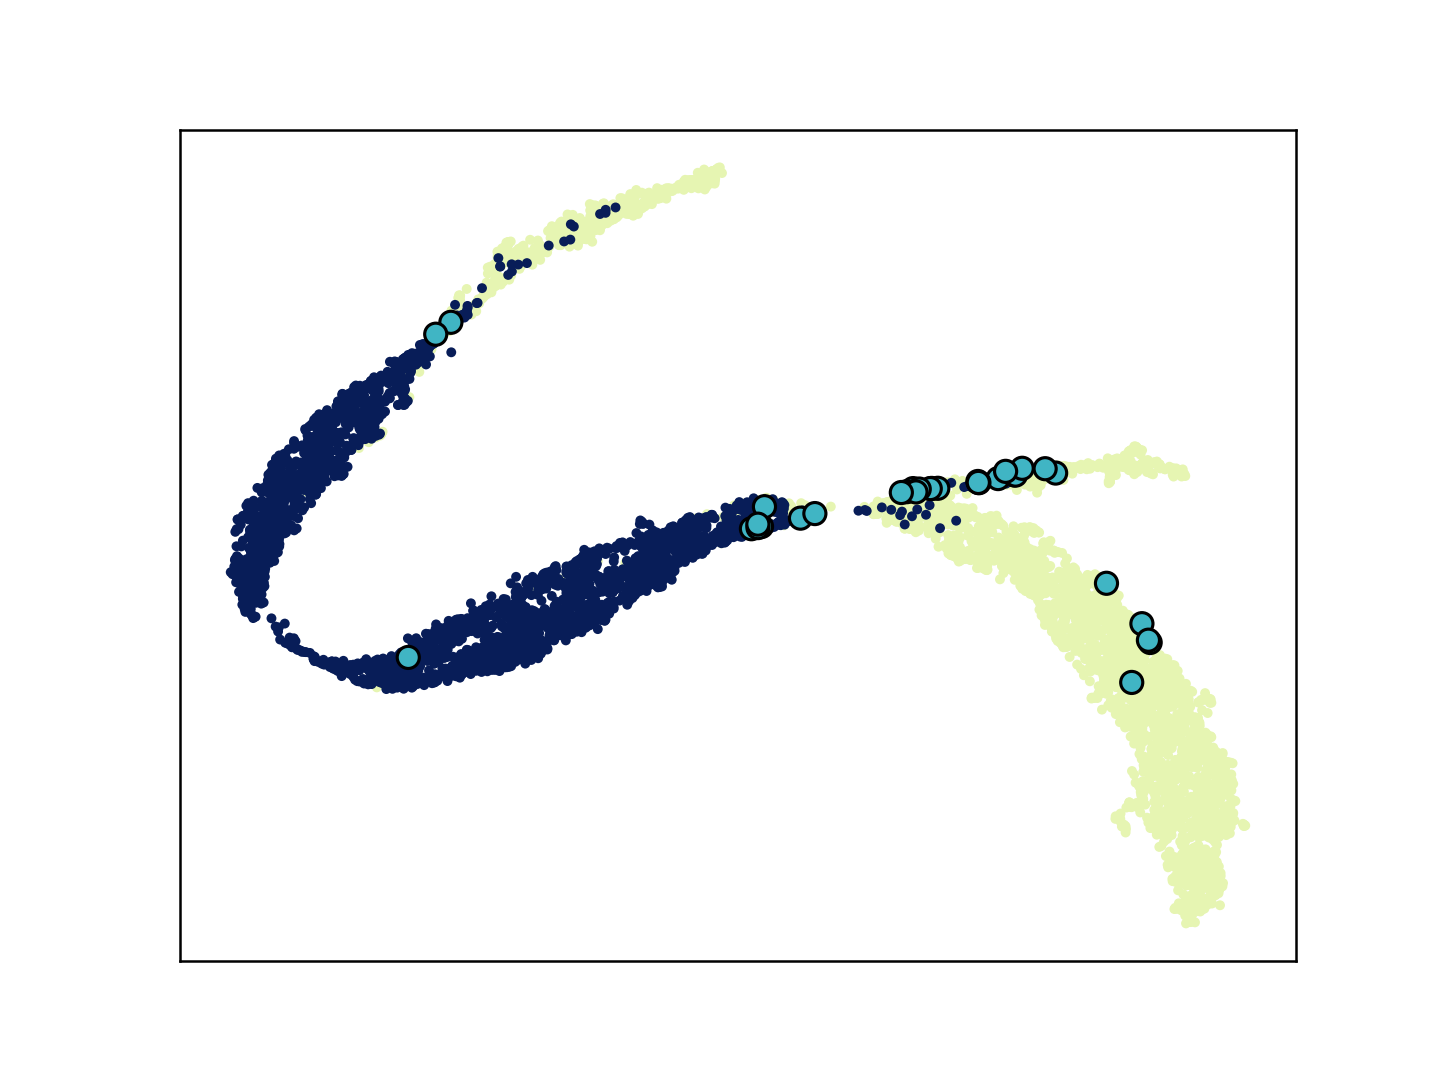

In [11]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding)

### Cross-Reference Against Fatlum's Data

In [12]:
TM_converted = np.loadtxt('files/TM_converted.csv', delimiter=',', skiprows=1)
Sol_converted = np.loadtxt('files/Sol_converted.csv', delimiter=',', skiprows=1)

In [13]:
fatlum_train_set = np.vstack([TM_converted, Sol_converted])
len_min, len_max = normalize_column(fatlum_train_set, 21)
iso_min, iso_max = normalize_column(fatlum_train_set, 22)

In [14]:
fatlum_test_set = np.zeros((len(df_test), 24))
for i, ind in enumerate(df_test.index):
    for j in range(24):
        fatlum_test_set[i, j] = df_test[str(j + 1)][ind]
_ = normalize_column(fatlum_test_set, 21, len_min, len_max)
_ = normalize_column(fatlum_test_set, 22, iso_min, iso_max)

In [15]:
mapper = umap.UMAP(random_state=42).fit(fatlum_train_set)
tm_embedding = mapper.transform(fatlum_train_set[:len(df_TM)])
sol_embedding = mapper.transform(fatlum_train_set[len(df_TM):])
exp_embedding = mapper.transform(fatlum_test_set)

/home/kormos/anaconda3/envs/env_umap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<IPython.core.display.Javascript object>


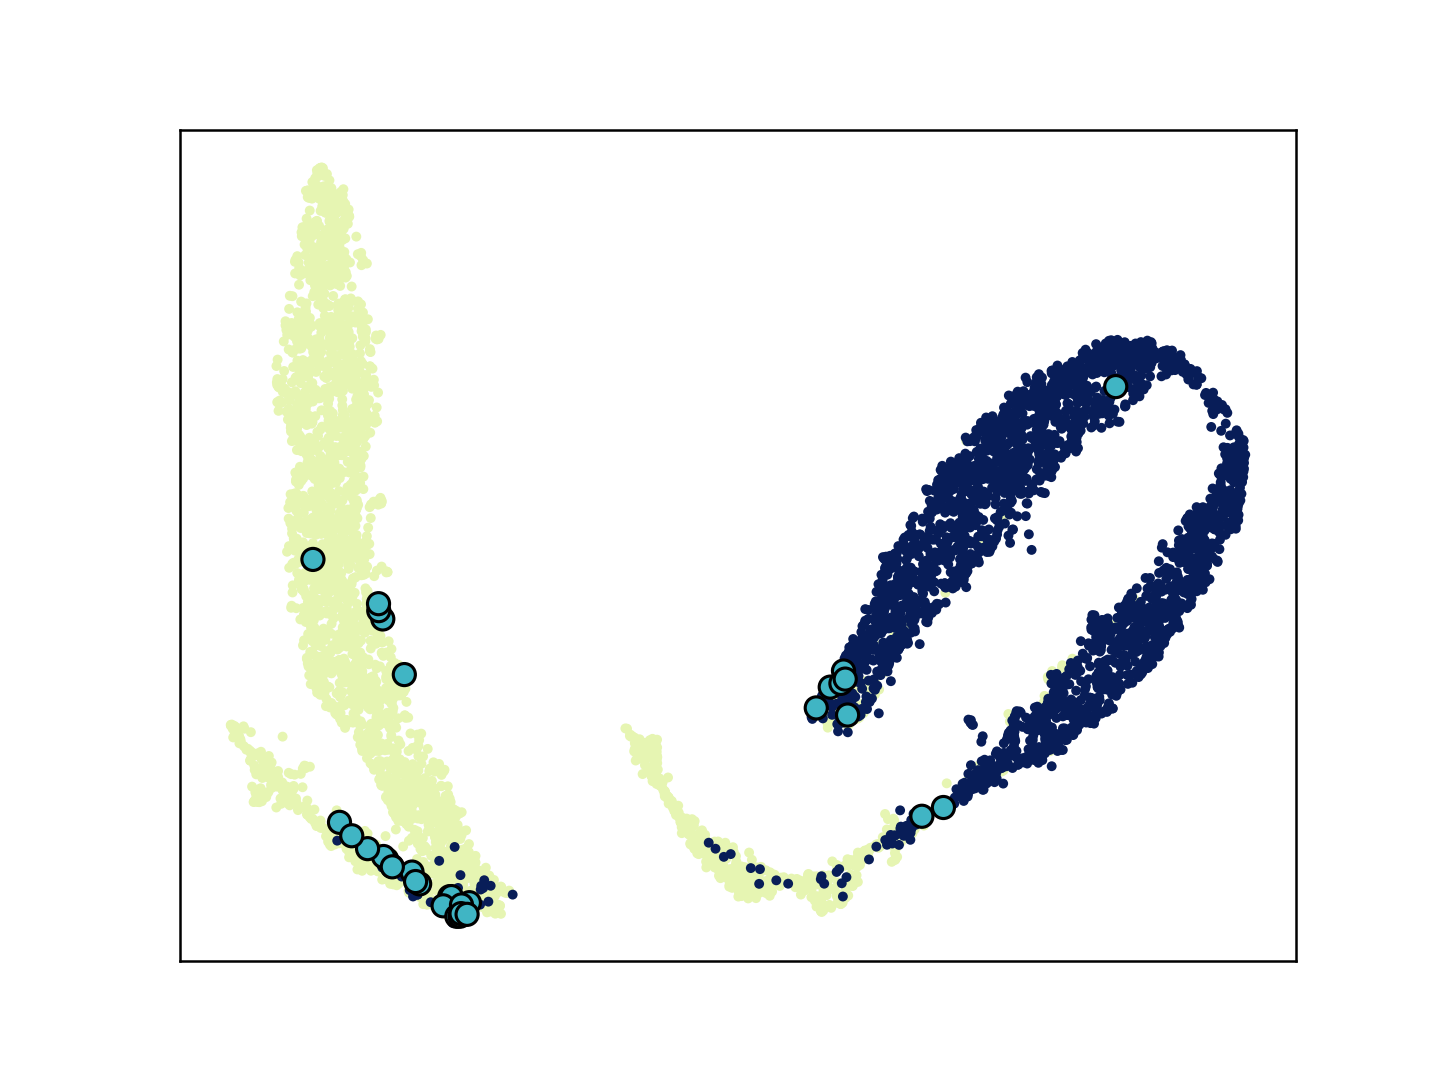

In [16]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding)

### Try Net Charge at pH7 Instead of Isoelectric Point

In [17]:
umap_train_set = np.zeros((len(df_train), 24))
for i, seq in zip(range(len(df_train)), df_train.seq):
    X = ProteinAnalysis(seq)
    _ = X.get_amino_acids_percent()
    umap_train_set[i, :20] = np.array(list(X.amino_acids_percent.values()))
    umap_train_set[i, 20] = gravy(seq)
    umap_train_set[i, 21] = len(seq)
    umap_train_set[i, 22] = X.charge_at_pH(7.)
    umap_train_set[i, 23] = hydrophobic_moment(seq)
len_min, len_max = normalize_column(umap_train_set, 21)
chg_min, chg_max = normalize_column(umap_train_set, 22)

In [18]:
umap_test_set = np.zeros((len(df_test), 24))
for i, seq in zip(range(len(df_test)), df_test.Sequence):
    X = ProteinAnalysis(seq)
    _ = X.get_amino_acids_percent()
    umap_test_set[i, :20] = np.array(list(X.amino_acids_percent.values()))
    umap_test_set[i, 20] = gravy(seq)
    umap_test_set[i, 21] = len(seq)
    umap_test_set[i, 22] = X.charge_at_pH(7.)
    umap_test_set[i, 23] = hydrophobic_moment(seq)
_ = normalize_column(umap_test_set, 21, len_min, len_max)
_ = normalize_column(umap_test_set, 22, chg_min, chg_max)

In [19]:
np.max(umap_train_set, axis=0)

array([0.58823529, 0.23809524, 0.26666667, 0.43478261, 0.4375    ,
       0.33333333, 0.23809524, 0.61904762, 0.3       , 0.65      ,
       0.28571429, 0.23529412, 0.19047619, 0.35294118, 0.33333333,
       0.28571429, 0.33333333, 0.54545455, 0.22222222, 0.26315789,
       3.69375   , 1.        , 1.        , 0.81403256])

In [20]:
np.min(umap_train_set, axis=0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.20322581e+00,  0.00000000e+00,  0.00000000e+00,  9.72975080e-04])

In [21]:
mapper = umap.UMAP(random_state=42).fit(umap_train_set)
tm_embedding = mapper.transform(umap_train_set[:len(df_TM)])
sol_embedding = mapper.transform(umap_train_set[len(df_TM):])
exp_embedding = mapper.transform(umap_test_set)

/home/kormos/anaconda3/envs/env_umap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<IPython.core.display.Javascript object>


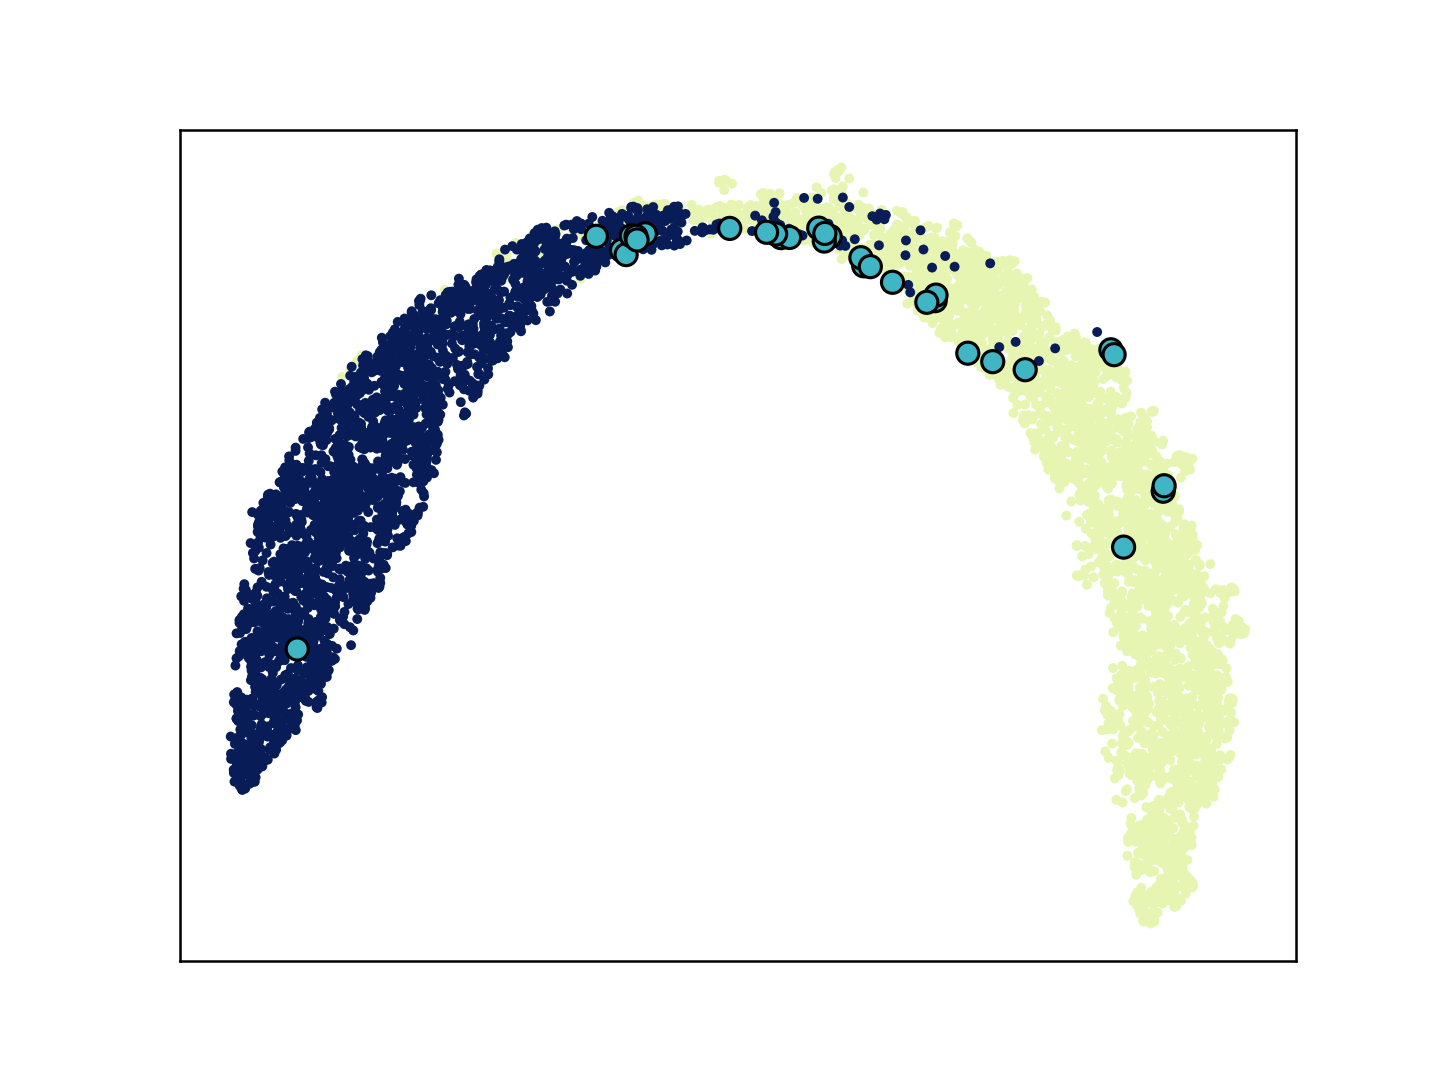

In [22]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding)

### Linear Least Squares of Eisenberg and Kyte-Doolittle vs WatTM Hydropathies

In [23]:
from scipy.optimize import lsq_linear

In [24]:
res = lsq_linear(np.vstack([np.array(hydropathies['WatTM']), np.ones(20)]).T, np.array(hydropathies['Kyte-Doolittle']))
print(res)
m_kd, b_kd = res.x

 active_mask: array([0., 0.])
        cost: 19.330254782596533
         fun: array([ 0.67982197, -0.8249046 ,  0.97243672,  1.02578386, -1.47121794,
       -1.66448746,  0.75875602, -1.40109624,  0.64705601, -0.40178373,
        0.20633063,  0.4579156 , -1.25795292,  0.80219758,  1.34008972,
       -1.52495184, -2.10957512, -1.06552011,  3.75927107,  1.07183079])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 7.993605777301127e-15
      status: 3
     success: True
           x: array([ 6.81665501, -1.30051085])


<IPython.core.display.Javascript object>


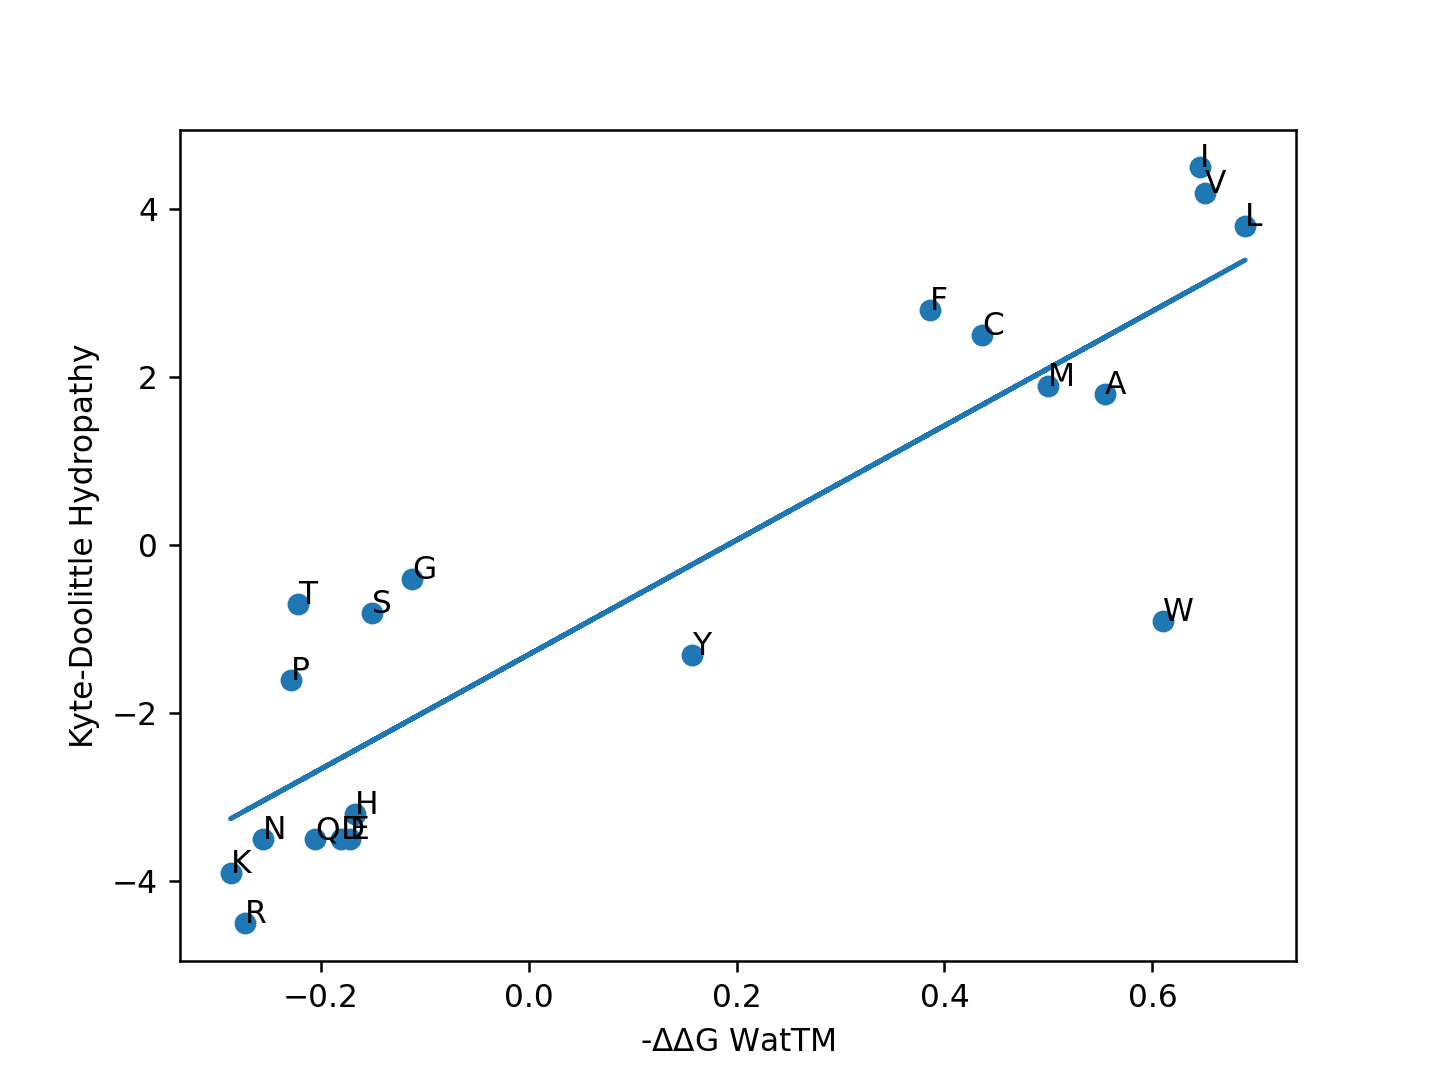

In [25]:
fig, ax = subplots()

ax.scatter(hydropathies['WatTM'], hydropathies['Kyte-Doolittle'])
ax.plot(hydropathies['WatTM'], m_kd * np.array(hydropathies['WatTM']) + b_kd)
ax.set_xlabel('-$\Delta \Delta$G WatTM')
ax.set_ylabel('Kyte-Doolittle Hydropathy')
for i, aa in enumerate(aas):
    ax.annotate(aa, (hydropathies['WatTM'][i], hydropathies['Kyte-Doolittle'][i]))

In [26]:
res = lsq_linear(np.vstack([np.array(hydropathies['WatTM']), np.ones(20)]).T, np.array(hydropathies['Eisenberg']))
print(res)
m_e, b_e = res.x

 active_mask: array([0., 0.])
        cost: 3.283872005925112
         fun: array([ 0.29507319,  0.37711768,  0.27217801,  0.12861554, -0.62958974,
       -0.96513725, -0.20122494, -0.2741729 ,  0.64867087,  0.13805244,
        0.15999157, -0.00635825, -0.84962294,  0.16972326,  1.70733678,
       -0.38539256, -0.66471658,  0.03678895,  0.22199053, -0.17932367])
     message: 'The unconstrained solution is optimal.'
         nit: 0
  optimality: 1.5543122344752192e-15
      status: 3
     success: True
           x: array([ 2.10037447, -0.24973778])


<IPython.core.display.Javascript object>


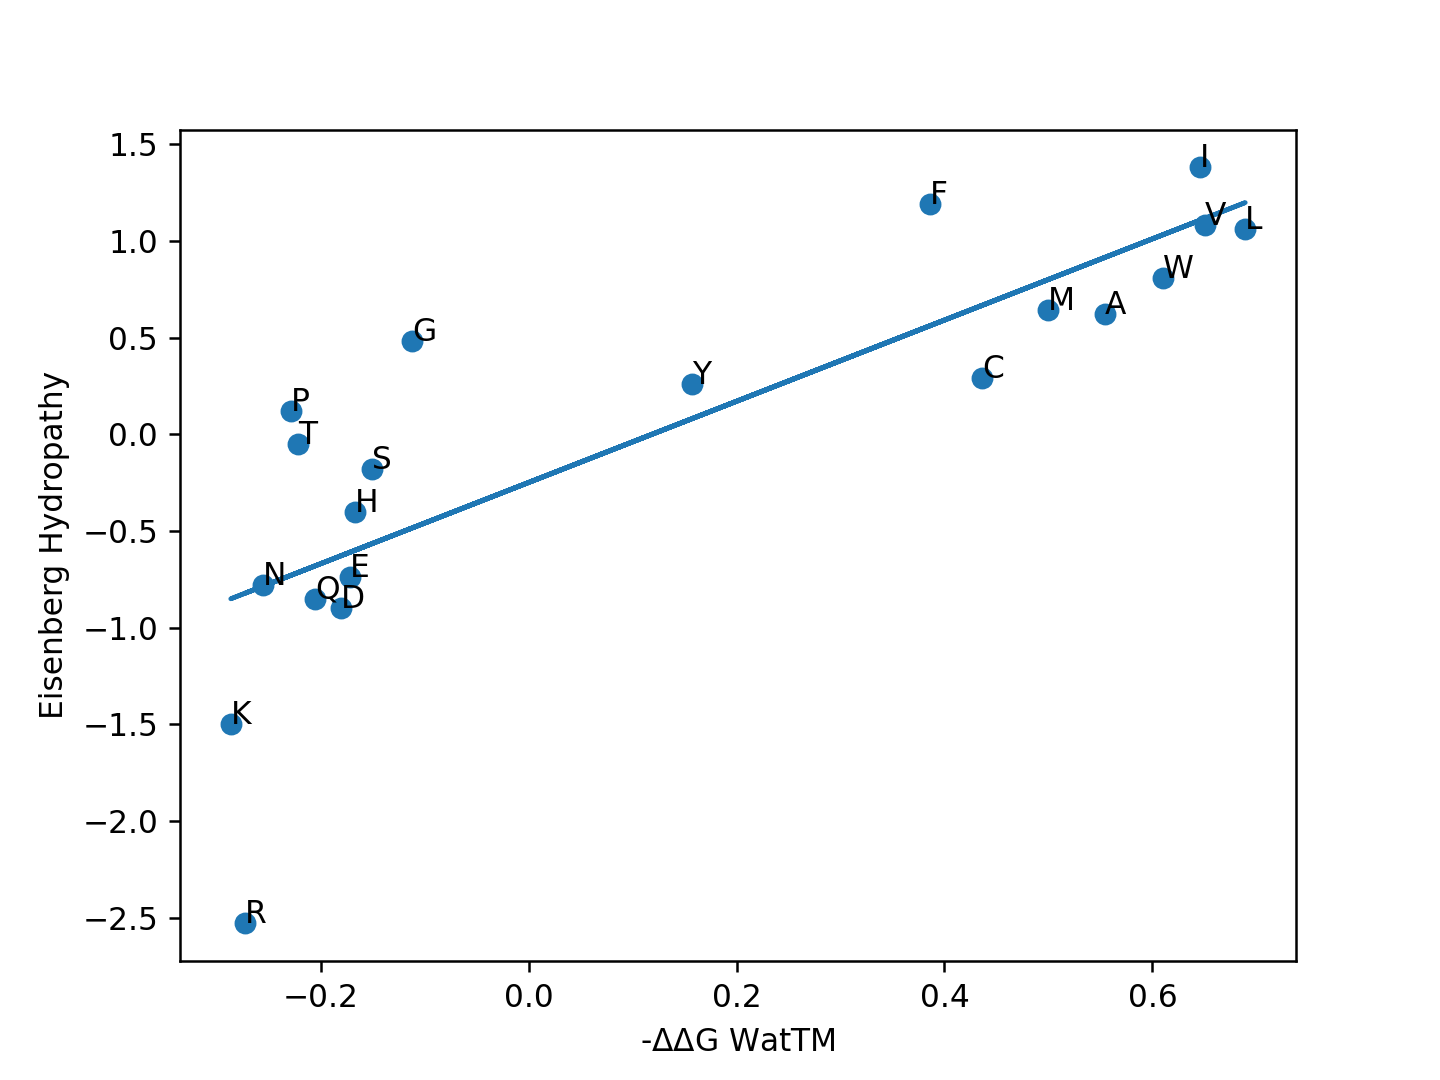

In [27]:
fig, ax = subplots()

ax.scatter(hydropathies['WatTM'], hydropathies['Eisenberg'])
ax.plot(hydropathies['WatTM'], m_e * np.array(hydropathies['WatTM']) + b_e)
ax.set_xlabel('-$\Delta \Delta$G WatTM')
ax.set_ylabel('Eisenberg Hydropathy')
for i, aa in enumerate(aas):
    ax.annotate(aa, (hydropathies['WatTM'][i], hydropathies['Eisenberg'][i]))

### Net Charge and Hydropathies with WatTM

In [28]:
umap_train_set = np.zeros((len(df_train), 24))
for i, seq in zip(range(len(df_train)), df_train.seq):
    X = ProteinAnalysis(seq)
    _ = X.get_amino_acids_percent()
    umap_train_set[i, :20] = np.array(list(X.amino_acids_percent.values()))
    umap_train_set[i, 20] = gravy(seq, 'WatTM')
    umap_train_set[i, 21] = len(seq)
    umap_train_set[i, 22] = X.charge_at_pH(7.)
    umap_train_set[i, 23] = hydrophobic_moment(seq, 'WatTM')
len_min, len_max = normalize_column(umap_train_set, 21)
chg_min, chg_max = normalize_column(umap_train_set, 22)
umap_train_set[:, 20] = m_kd * umap_train_set[:, 20] + b_kd
umap_train_set[:, 23] = m_e * umap_train_set[:, 23] + b_e

In [29]:
umap_test_set = np.zeros((len(df_test), 24))
for i, seq in zip(range(len(df_test)), df_test.Sequence):
    X = ProteinAnalysis(seq)
    _ = X.get_amino_acids_percent()
    umap_test_set[i, :20] = np.array(list(X.amino_acids_percent.values()))
    umap_test_set[i, 20] = gravy(seq, 'WatTM')
    umap_test_set[i, 21] = len(seq)
    umap_test_set[i, 22] = X.charge_at_pH(7.)
    umap_test_set[i, 23] = hydrophobic_moment(seq, 'WatTM')
_ = normalize_column(umap_test_set, 21, len_min, len_max)
_ = normalize_column(umap_test_set, 22, chg_min, chg_max)
umap_test_set[:, 20] = m_kd * umap_test_set[:, 20] + b_kd
umap_test_set[:, 23] = m_e * umap_test_set[:, 23] + b_e

In [30]:
np.max(umap_train_set, axis=0)

array([0.58823529, 0.23809524, 0.26666667, 0.43478261, 0.4375    ,
       0.33333333, 0.23809524, 0.61904762, 0.3       , 0.65      ,
       0.28571429, 0.23529412, 0.19047619, 0.35294118, 0.33333333,
       0.28571429, 0.33333333, 0.54545455, 0.22222222, 0.26315789,
       2.99228005, 1.        , 1.        , 0.35158265])

In [31]:
np.min(umap_train_set, axis=0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -1.75015994,  0.        ,  0.        , -0.24853658])

In [32]:
mapper = umap.UMAP(random_state=42).fit(umap_train_set)
tm_embedding = mapper.transform(umap_train_set[:len(df_TM)])
sol_embedding = mapper.transform(umap_train_set[len(df_TM):])
exp_embedding = mapper.transform(umap_test_set)

/home/kormos/anaconda3/envs/env_umap/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<IPython.core.display.Javascript object>


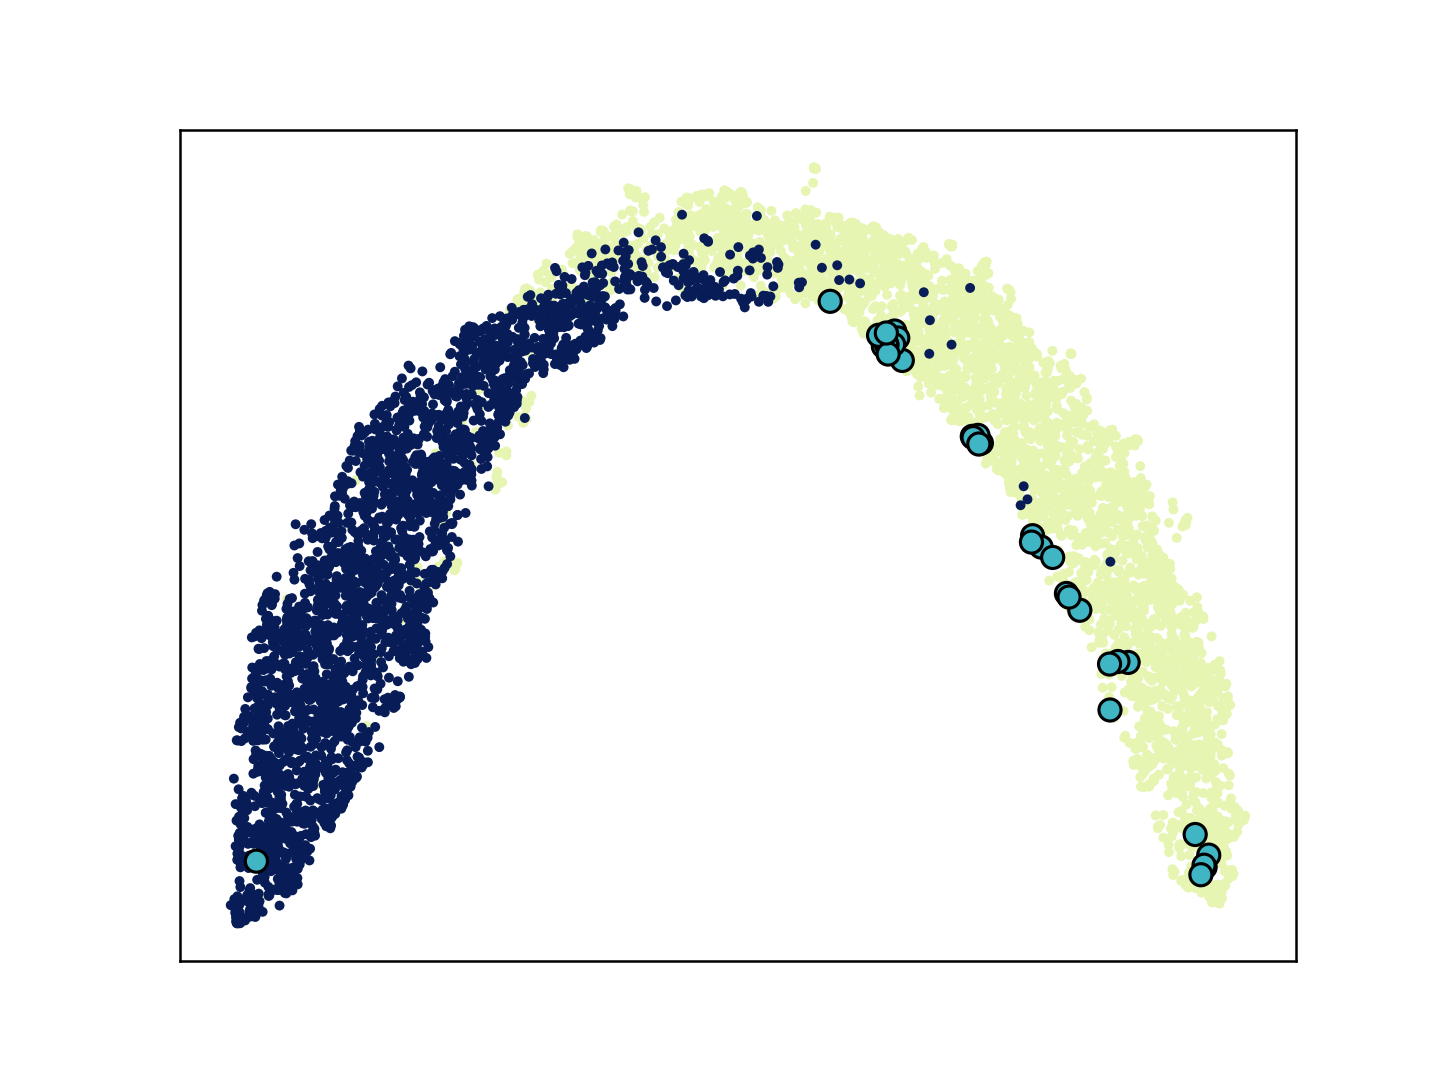

In [33]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding)

<IPython.core.display.Javascript object>


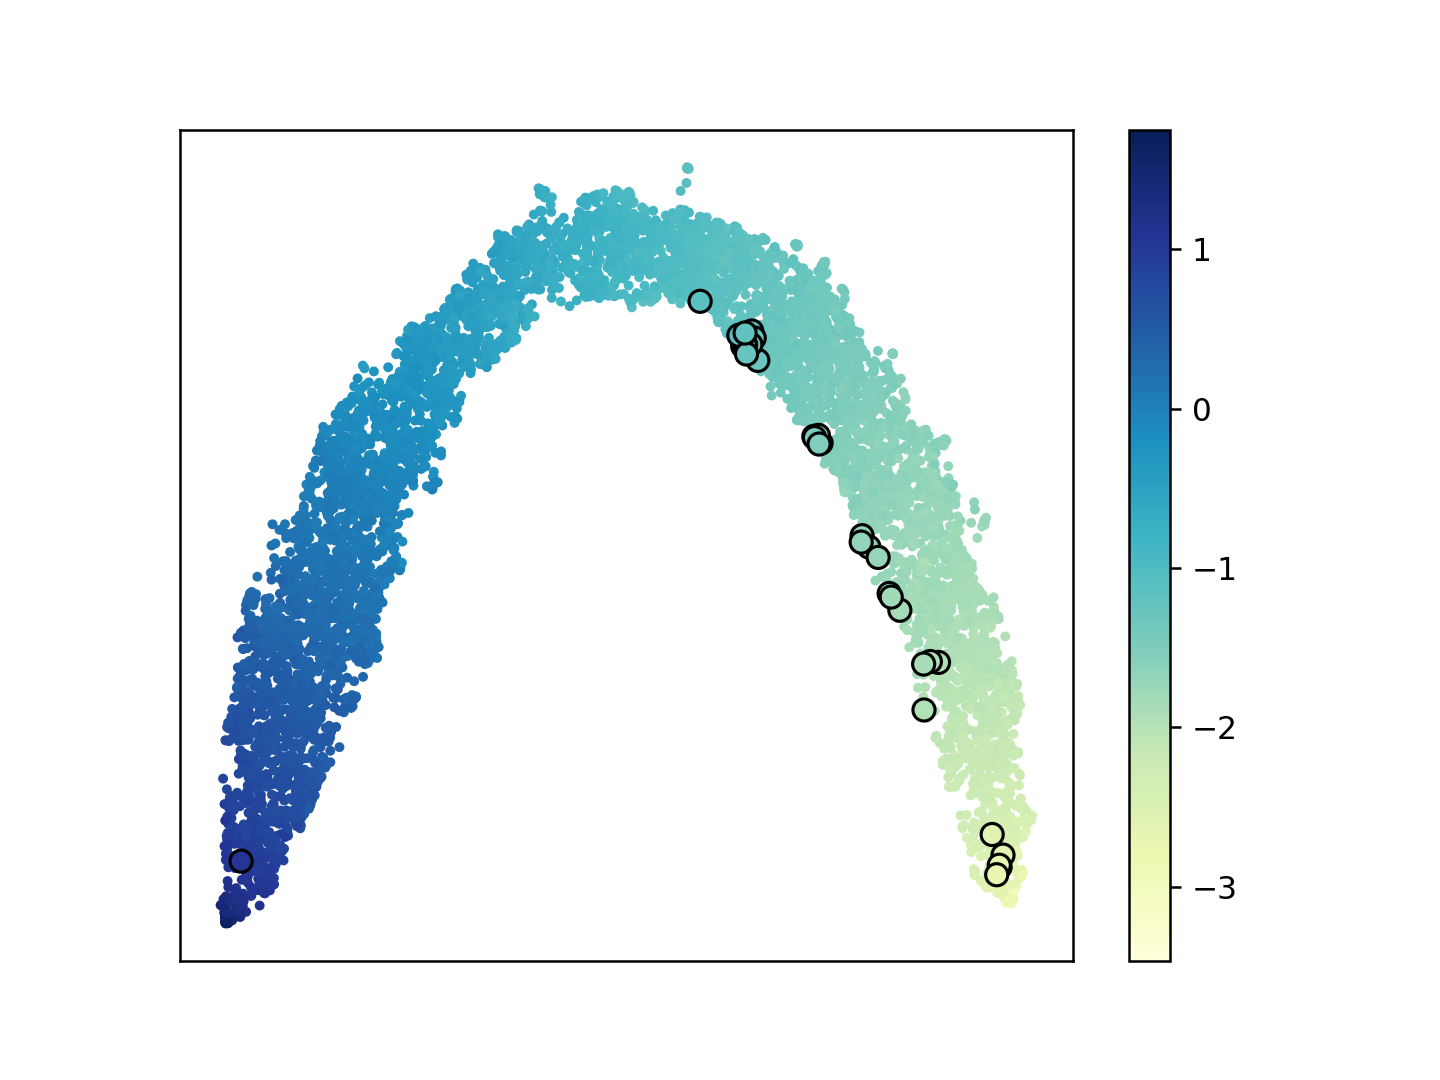

In [40]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding, umap_train_set, umap_test_set, color_by='gravy')

<IPython.core.display.Javascript object>


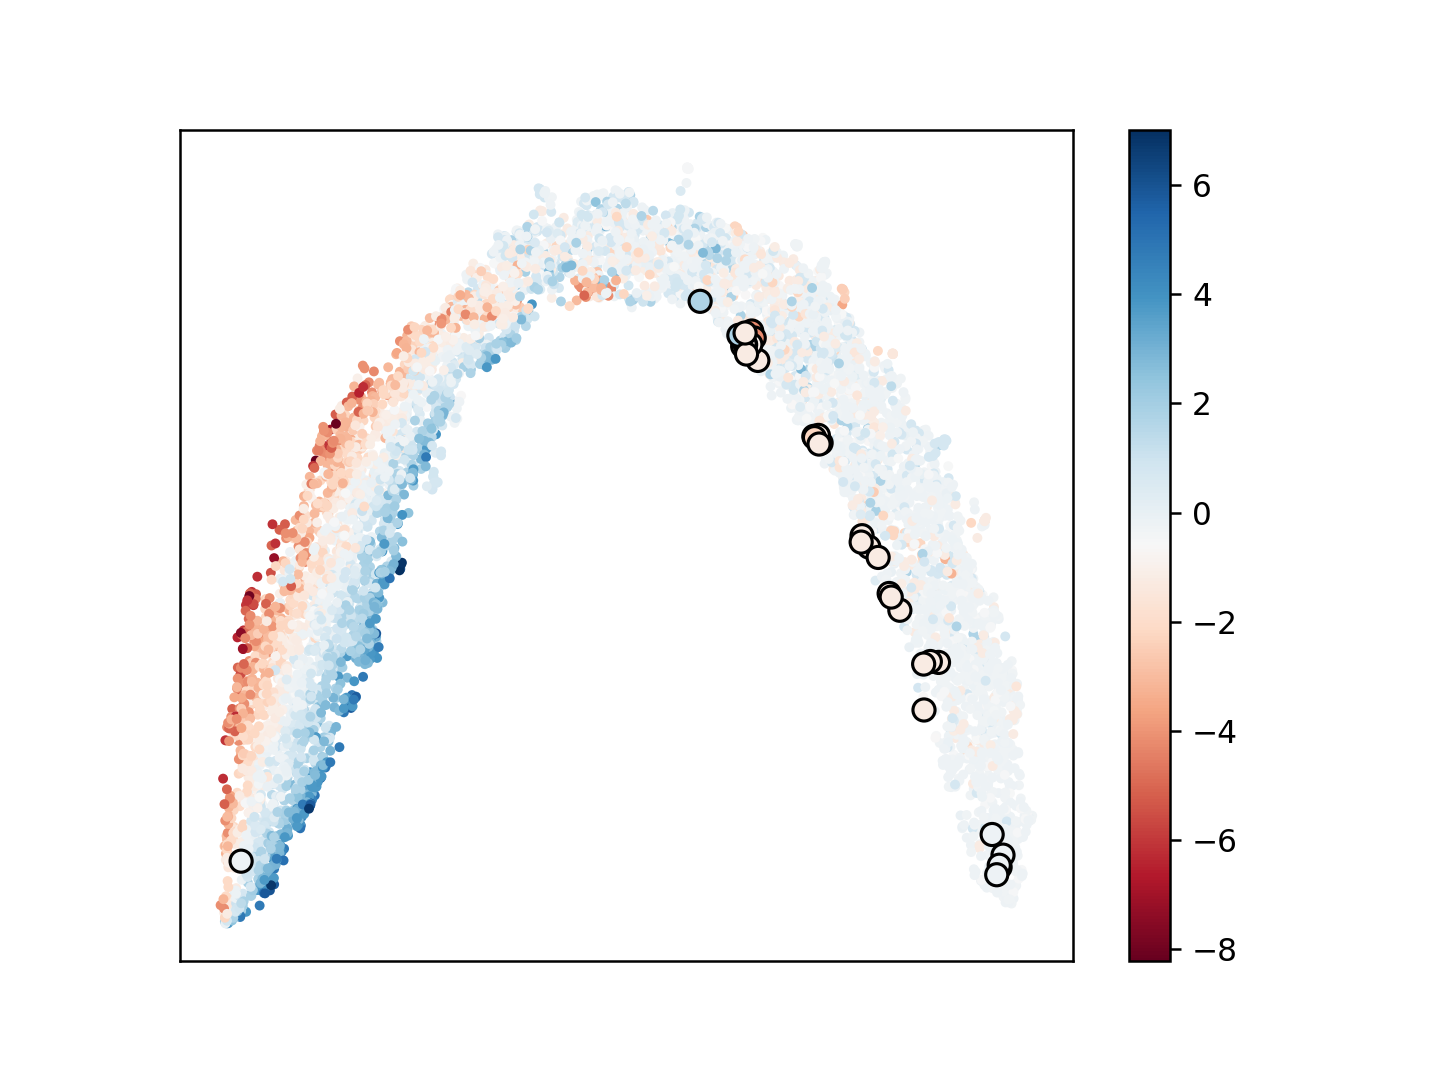

In [35]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding, umap_train_set, umap_test_set, 
                 chg_min, chg_max, color_by='charge')

<IPython.core.display.Javascript object>


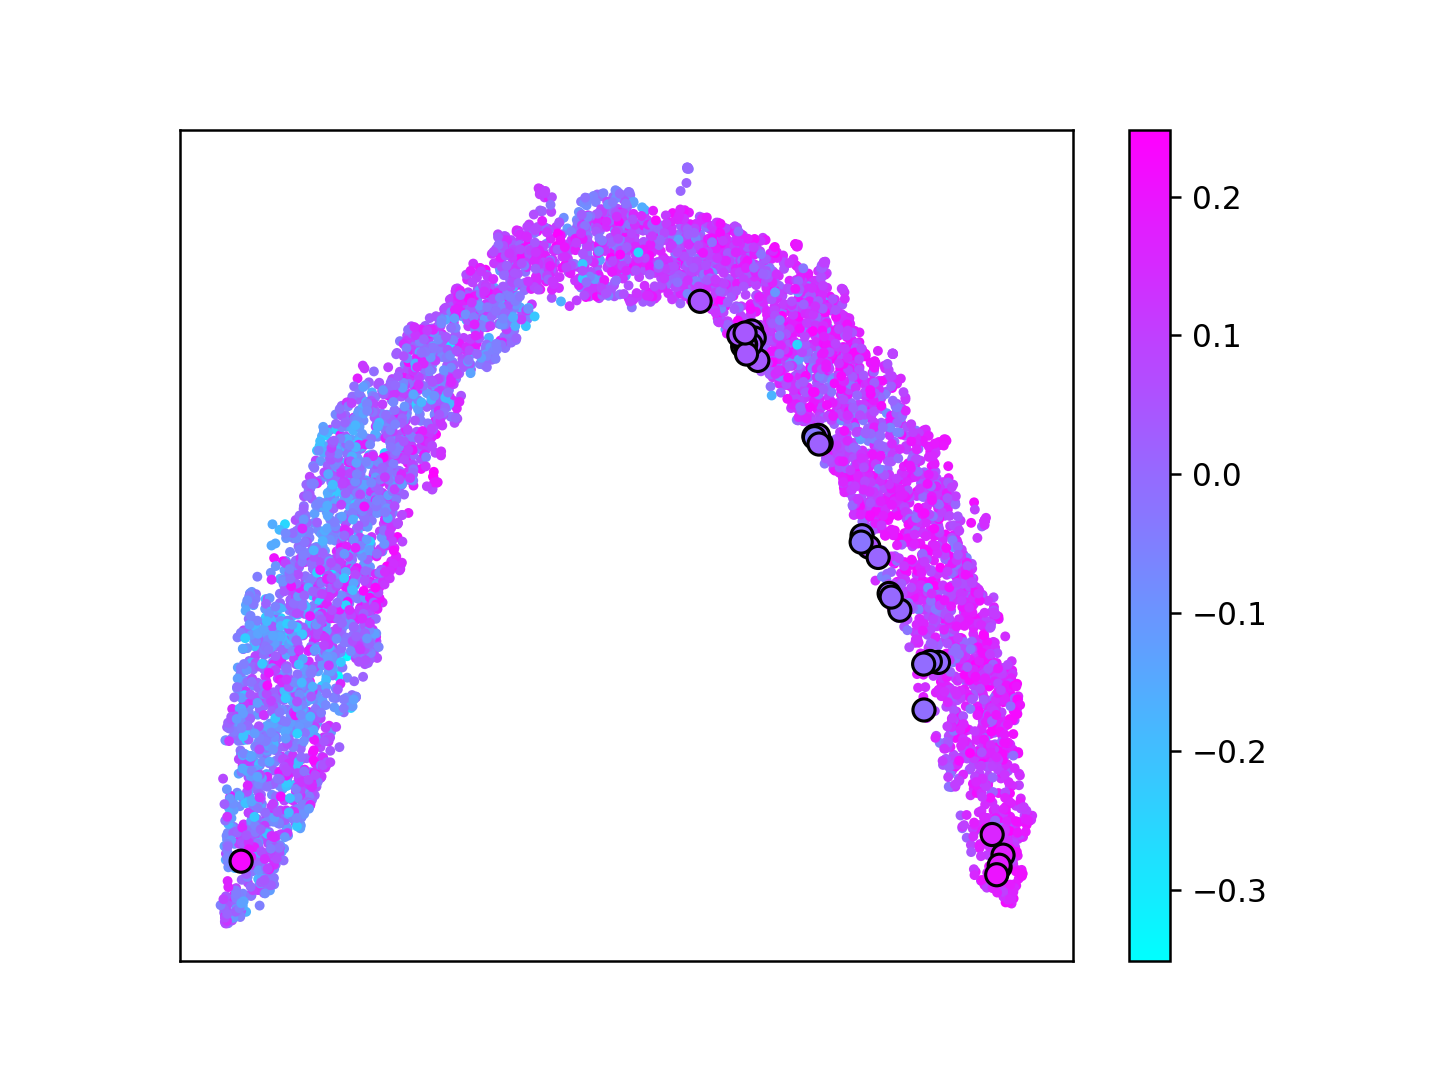

In [41]:
interactive_plot(tm_embedding, sol_embedding, exp_embedding, umap_train_set, umap_test_set, color_by='moment')

### Plot Dispositional Probabilities Along the Arch

In [37]:
df_test_full = pd.read_csv('files/Experiment_combined.csv')

In [38]:
# sequences in the order they appear along the UMAP arch shape
seqs_in_order = [seq.strip() for seq in '''
DKQEGEWPTGLRLSRIGGI
WARYADWLFTKKKLLLLDLLALLV
WARYADWLFTRRRLLLLDLLALLV
WARYADWLFTNNNLLLLDLLALLV
WARYADWLFTTTTLLLLDLLALLV
WARYADWLFTQQQLLLLDLLALLV
WARYADWLFTPPPLLLLDLLALLV
WARYADWLFTSSSLLLLDLLALLV
WARYADWLFTHHHLLLLDLLALLV
WARYADWLFTDDDLLLLDLLALLV
WARYADWLFTEEELLLLDLLALLV
WARYADWLFTGGGLLLLDLLALLV
WARYADWLFTAGGLLLLDLLALLV
WARYADWLFTDLPLLLLDLLALLV
WARYADWLFTGGALLLLDLLALLV
WARYADWLFTYYYLLLLDLLALLV
WARYADWLFTGAGLLLLDLLALLV
WARYADWLFTAAGLLLLDLLALLV
WARYADWLFTGAALLLLDLLALLV
WARYADWLFTAGALLLLDLLALLV
WARYADWLFTFFFLLLLDLLALLV
WARYADWLFTCCCLLLLDLLALLV
WARYADWLFTMMMLLLLDLLALLV
WARYADWLFTAAALLLLDLLALLV
WARYADWLFTWWWLLLLDLLALLV
WARYADWLFTVVVLLLLDLLALLV
WARYADWLFTIIILLLLDLLALLV
WARYADWLFTLLLLLLLDLLALLV
AAAAAAALAAALAAAAAAA
AAAAAAALALALAAAAAAA
AAAALALAAAAALALAAAA
AAALAALAAAAALAALAAA
AAALAALAALAALAALAAA
'''.split('\n') if len(seq)]

<IPython.core.display.Javascript object>


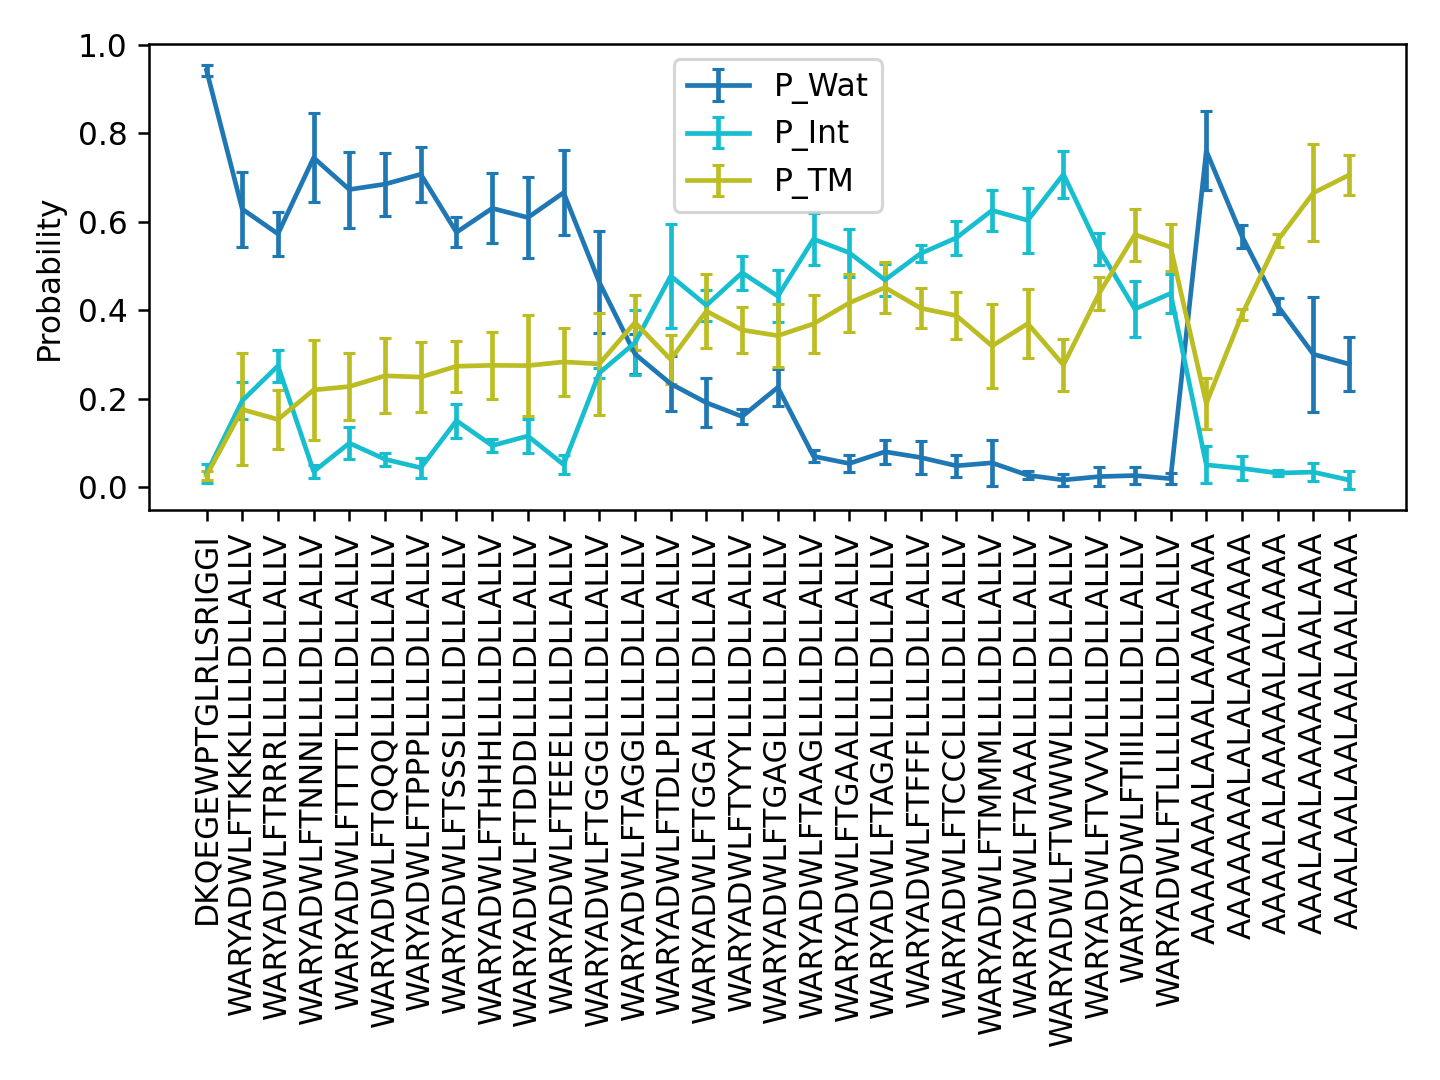

In [39]:
fig = figure()

x = np.arange(33)

errorbar(x, [df_test_full[df_test_full.Sequence == seq].P_Wat.mean() for seq in seqs_in_order], 
         yerr=[df_test_full[df_test_full.Sequence == seq].P_Wat.std() for seq in seqs_in_order], 
         label='P_Wat', capsize=2, color='tab:blue')
errorbar(x, [df_test_full[df_test_full.Sequence == seq].P_Int.mean() for seq in seqs_in_order], 
         yerr=[df_test_full[df_test_full.Sequence == seq].P_Int.std() for seq in seqs_in_order], 
         label='P_Int', capsize=2, color='tab:cyan')
errorbar(x, [df_test_full[df_test_full.Sequence == seq].P_TM.mean() for seq in seqs_in_order], 
         yerr=[df_test_full[df_test_full.Sequence == seq].P_TM.std() for seq in seqs_in_order], 
         label='P_TM', capsize=2, color='tab:olive')
xticks(np.arange(33), labels=seqs_in_order, rotation=90)
ylabel('Probability')
legend()
tight_layout()
show()